In [1]:
from fem.definitions import local_stiffness_matrix, local_mass_matrix
from fem.construction import construct_global_stiffness_matrix, construct_global_mass_matrix

#from obj.parser import parse_obj
#from obj.transforms import to_numpy_array, enforce_fem_order
from obj.generate import rectangular_domain

from math import sin, pi, cos,sqrt

import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

#### Load in the mesh

In [2]:
N = 64
obj = rectangular_domain(N=N)
#obj

#### Set parameters and create domain

In [3]:
parameters = (1, [0, 0], 0)

def known_nodes(v):
    return abs(v[0]) == 1 or abs(v[1]) == 1 or v[0] == 0 or v[1] == 0

domain = {'obj': obj, 'known_nodes': known_nodes}

#### Construct the global system

In [4]:
A = construct_global_stiffness_matrix(domain, parameters)
M = construct_global_mass_matrix(domain, parameters)

def f (x, y):
    return (2*pi**2) * (sin(pi * x)) * (sin(pi * y))

verts = [(x,y) for x, y, _ in obj['vertices']]
F = np.array([f(x,y) for x, y in verts])

array([[ 4., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  4., -1., ...,  0.,  0.,  0.],
       [ 0., -1.,  4., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  4., -1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  4., -1.],
       [ 0.,  0.,  0., ...,  0., -1.,  4.]])

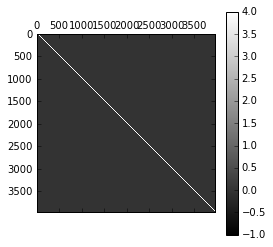

In [5]:
plt.matshow(A.A, cmap=plt.cm.gray)
plt.colorbar()
A.A

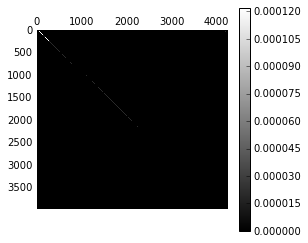

In [6]:
plt.matshow(M.A, cmap=cm.gray)
plt.colorbar()

In [7]:
M.shape

(3969, 4225)

In [8]:
M*F

array([  9.66429535e-06,   2.12367700e-05,   3.27580835e-05, ...,
         3.27580835e-05,   2.12367700e-05,   9.66429535e-06])

#### Solve it

In [9]:
u = np.linalg.solve(A.A, M*F)
u = np.append(u, [0.0 for _ in range(4*N)])
len(u)

4225

#### Plot results and compare with the actual solution

In [10]:
xs = [x for x, _ in verts]
ys = [y for _, y in verts]

co = list(zip(xs,ys,u))

xi = list(set(xs))
xi.sort()
yi = list(set(ys))
yi.sort()

coords = [(xi.index(x), yi.index(y), z) for x, y, z in co]

zs = np.matrix(np.identity(N+1))

for x, y, z in coords:
    zs[x, y] = z

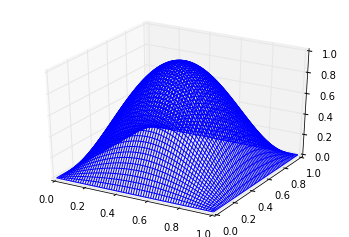

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.linspace(0,1,128)
Y = np.linspace(0,1,128)
X, Y = np.meshgrid(X, Y)
Z = np.sin(pi * X) * np.sin(pi * Y)
ax.plot_wireframe(X, Y, Z, rstride=3, cstride=3, color='lightgrey')


Xs, Ys = np.meshgrid(xi, yi)

#Zs = (Xs + Ys) - (Xs + Ys)

ax.plot_wireframe(Xs, Ys, zs, color='blue')
#ax.scatter(xs, ys, u, c='r', marker='^')

In [12]:
def L2_error(grid, soln, exact):
    """
    Given a grid and the approximate solution, calculate the L^2 error
    """
    xs, ys = grid
    
    err = 0
    
    for y in ys:
        for x in xs:
            err += (soln[x, y] - exact(x,y))**2
            
    err = (1 / len(xs)**2) * sqrt(err)
    
    return err
    

In [13]:
print(L2_error((xi, yi), zs, f))

0.14950406666847077
